In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score


pd.set_option.max_cols = 100
pd.set_option.max_rows = 100

## TRATAMIENTO DE LOS DATOS

In [3]:
def clip_series(s, low, up):
    lower = s.quantile(low)
    upper = s.quantile(up)
    return np.clip(s, lower, upper)

In [29]:
data = pd.read_csv('train.csv', index_col = 0)
# drop nulls
data = data.dropna()
# rename target
data = data.rename(
    columns={
        'SeriousDlqin2yrs': 'target',
        'NumberOfTime30-59DaysPastDueNotWorse': 'n30to59DaysLate',
        'NumberOfTime60-89DaysPastDueNotWorse': 'n60to89DaysLate',
        'NumberOfTimes90DaysLate': 'n90DaysLate'
        }
        )
# transform age
data['age'] = data.age.str.replace('y', '').astype(int)
# windsorize 1-99
data.age = clip_series(data.age, .01, .99)
data.RevolvingUtilizationOfUnsecuredLines = clip_series(data.RevolvingUtilizationOfUnsecuredLines, .01, .99)
data.n30to59DaysLate = clip_series(data.n30to59DaysLate, .01, .99)
data.n60to89DaysLate = clip_series(data.n60to89DaysLate, .01, .99)
data.n90DaysLate = clip_series(data.n90DaysLate, .01, .99)
data.DebtRatio = clip_series(data.DebtRatio, .01, .98)
data.MonthlyIncome = clip_series(data.MonthlyIncome, .01, .99)
data.NumberOfOpenCreditLinesAndLoans = clip_series(data.NumberOfOpenCreditLinesAndLoans, .01, .99)
data.NumberRealEstateLoansOrLines = clip_series(data.NumberRealEstateLoansOrLines, .01, .99)
data.NumberOfDependents = clip_series(data.NumberOfDependents, .01, .99)

<AxesSubplot:>

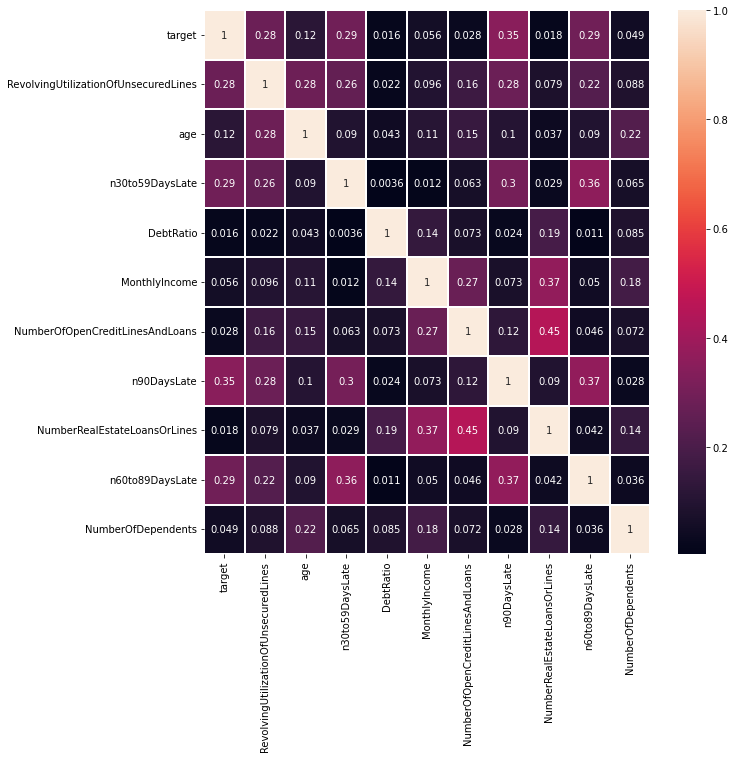

In [5]:
fig, ax = plt.subplots (1,1, figsize = (10,10))
sns.heatmap(
    abs(data.corr()),
    annot = True,
    linewidths=0.1)

In [6]:
data.columns

Index(['target', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'n30to59DaysLate', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'n90DaysLate',
       'NumberRealEstateLoansOrLines', 'n60to89DaysLate',
       'NumberOfDependents'],
      dtype='object')

## MODELO

In [7]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import sklearn.metrics
#sklearn.metrics.SCORERS.keys()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target','MonthlyIncome']), data.target, random_state=0, test_size=0.30, shuffle=True)

In [38]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)# utilizamos esto para que nos ponga los valores de 0 a 1
# X_train_scaler = scaler.transform(X_train)
# X_test_scaler =scaler.transform(X_test)


### XGBOOST

In [31]:
#model_xgb = XGBClassifier(random_state=42,max_depth = 5, min_child_weight = 1,Gamma = 0,scale_pos_weight = 1)
#model_xgb = XGBClassifier(max_depth = 5, min_child_weight = 1,Gamma = 0,scale_pos_weight = 1) 64
# model_xgb = XGBClassifier(objective='binary:logistic',max_depth = 4, min_child_weight = 1,Gamma = 0,scale_pos_weight = 1) 0.63 -0.579
#model_xgb = XGBClassifier(objective='binary:logistic',max_depth = 5, min_child_weight = 1,Gamma = 0,scale_pos_weight = 1) 0.66 -0.58
model_xgb = XGBClassifier(eval_metric='mlogloss',max_depth = 7, min_child_weight =160,alpha=0.3212959955044835, scale_pos_weight = 14, eta =0.11284045211634955)
model_xgb.fit(X_train, y_train)
predictions_xgb_train = model_xgb.predict_proba(X_train)[:,1]
predictions_xgb_test = model_xgb.predict_proba(X_test)[:,1]
print ('roc :', roc_auc_score(y_train,predictions_xgb_train ))
print ('roc :', roc_auc_score(y_test,predictions_xgb_test ))

C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


roc : 0.8886501320963658
roc : 0.8550520632055736


### XGBOOST CON SMOTE

In [33]:
# cCON SMOTE NO SE TRAGA LOS VALORES NAN


X_train_smot, y_train_smot = SMOTE(random_state=0).fit_resample(X_train,y_train)

model_xgb = XGBClassifier(eval_metric='mlogloss',max_depth = 7, min_child_weight =160,alpha=0.3212959955044835, scale_pos_weight = 14, eta =0.11284045211634955,num_iterations=1000)
model_xgb.fit(X_train_smot,y_train_smot)
predictions_xgb_train = model_xgb.predict_proba(X_train_smot)[:,1]
predictions_xgb_test = model_xgb.predict_proba(X_test)[:,1]
print ('roc :', roc_auc_score(y_train_smot,predictions_xgb_train ))
print ('roc :', roc_auc_score(y_test,predictions_xgb_test ))


C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_iterations" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


roc : 0.9825177071586078
roc : 0.8351626144712415


### XGBOOST CON NEARMISSIN

In [32]:

# CON NEARMISSIN NO SE TRAGA LOS VALORES NAN


from imblearn.under_sampling import NearMiss

model_xgb = XGBClassifier(eval_metric='mlogloss', max_depth = 7,min_child_weight=160,scale_pos_weight =14,num_iterations=100)
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

model_xgb.fit(X_train_res,y_train_res)

predictions_xgb_train = model_xgb.predict_proba(X_train_res)[:,1]
predictions_xgb_test = model_xgb.predict_proba(X_test)[:,1]

print ('roc :', roc_auc_score(y_train_res,predictions_xgb_train ))
print ('roc :', roc_auc_score(y_test,predictions_xgb_test ))


C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_iterations" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


roc : 0.9928759262973864
roc : 0.6674632884381861


### RANDOM FOREST

In [34]:
model_lgtree = RandomForestClassifier()

parameters = {'n_estimators' : [10,100],
              'max_depth': [2,3,5],
              'random_state': [42,0,30],
              'bootstrap': ['True', 'False'],
              'criterion': ['gini','entropy']
            }

lgtree_gs = GridSearchCV(model_lgtree, parameters, cv=3, scoring='roc_auc')

lgtree_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': ['True', 'False'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5], 'n_estimators': [10, 100],
                         'random_state': [42, 0, 30]},
             scoring='roc_auc')

In [35]:
print (lgtree_gs.best_params_)
print (lgtree_gs.best_estimator_)


{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100, 'random_state': 42}
RandomForestClassifier(bootstrap='True', criterion='entropy', max_depth=5,
                       random_state=42)


In [36]:
model_lgtree =RandomForestClassifier(bootstrap = True,
                                     criterion = 'entropy',
                                     max_depth = 5,
                                     n_estimators = 100,
                                     random_state =42)
model_lgtree.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, random_state=42)

In [37]:
predictions_lgtree_train = model_lgtree.predict_proba(X_train)[:,1]
predictions_lgtree_test = model_lgtree.predict_proba(X_test)[:,1]

In [38]:
print ('roc :', roc_auc_score(y_train,predictions_lgtree_train ))
print ('roc :', roc_auc_score(y_test,predictions_lgtree_test ))

roc : 0.8553560599072969
roc : 0.8550218132986539


### ADA

In [39]:


estimator = DecisionTreeClassifier(max_depth=5)

model_ada = AdaBoostClassifier(base_estimator = estimator,
                             n_estimators=200,
                             learning_rate=0.4,
                             random_state=0,
                             )

model_ada.fit(X_train, y_train)

predictions_ada_train = model_ada.predict_proba(X_train)[:,1]
predictions_ada_test = model_ada.predict_proba(X_test)[:,1]



print ('roc :', roc_auc_score(y_train,predictions_ada_train ))
print ('roc :', roc_auc_score(y_test,predictions_ada_test ))

roc : 0.9972832439956824
roc : 0.7074794011136676


### ADA CON SMOTE

In [44]:

X_train_smot, y_train_smot = SMOTE(random_state=0).fit_resample(X_train,y_train)


estimator = DecisionTreeClassifier(max_depth=5)

model_ada = AdaBoostClassifier(base_estimator = estimator,
                             n_estimators=200,
                             learning_rate=0.4,
                             random_state=0,
                             )

model_ada.fit(X_train_smot,y_train_smot)

predictions_ada_train = model_ada.predict_proba(X_train_smot)[:,1]
predictions_ada_test = model_ada.predict_proba(X_test)[:,1]



print ('roc :', roc_auc_score(y_train_smot,predictions_ada_train ))
print ('roc :', roc_auc_score(y_test,predictions_ada_test ))


roc : 0.9993681952282294
roc : 0.7206069861636053


### BAGGIN

In [41]:



kfold = KFold(n_splits=5)

estimator = DecisionTreeClassifier()

bag_clf = BaggingClassifier(
    base_estimator = estimator,
    n_estimators=500, # Cantidad de árboles
    max_samples=100, # Muestras utilizadas en boostrapping
    bootstrap=False, # Usamos boostrapping esto hace que cada modelo coja una porcion distinta de los datos (osea con reemplazamiento). digamos quee s como un crossvalidation. si esto está
    #activado será baggin y si es FAlse sera pasting (esto es sin reemplazamiento)
    # max_features = 3 # Features que utiliza en el boostrapping. Cuanto más bajo, mejor generalizará y menos overfitting
    #el max_features seria una forma de regularizacion
    random_state=42)


bag_clf.fit(X_train, y_train)
predictions_bag_clf_train = bag_clf.predict_proba(X_train)[:,1]
predictions_bag_clf_test = bag_clf.predict_proba(X_test)[:,1]

print ('roc :', roc_auc_score(y_train,predictions_bag_clf_train ))
print ('roc :', roc_auc_score(y_test,predictions_bag_clf_test ))

roc : 0.846840504107932
roc : 0.8340566266236397


### VOTIN CLASIFIER

In [42]:
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # PROBABILITY = TRUE

estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]

soft_voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Train the model
soft_voting_clf.fit(X_train, y_train)



predictions_soft_voting_train = bag_clf.predict_proba(X_train)[:,1]
predictions_soft_voting_test = bag_clf.predict_proba(X_test)[:,1]

print ('roc :', roc_auc_score(y_train,predictions_soft_voting_train ))
print ('roc :', roc_auc_score(y_test,predictions_soft_voting_test ))

C:\Users\Laura\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


roc : 0.846840504107932
roc : 0.8340566266236397


### KNN

In [45]:




model_knn = KNeighborsClassifier()



model_knn.fit(X_train,y_train)

predictions_knn_train = model_knn.predict_proba(X_train)[:,1]
predictions_knn_test = model_knn.predict_proba(X_test)[:,1]



print ('roc :', roc_auc_score(y_train, predictions_knn_train))
print ('roc :', roc_auc_score(y_test,predictions_knn_test ))

roc : 0.9219587963909064
roc : 0.5586888671544032


### KNN DIRECTAMENTE CON SMOTE

In [24]:


X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target']), data.target, random_state= 42, shuffle=True, test_size=0.20)
X_train_smot, y_train_smot = SMOTE(random_state=0).fit_resample(X_train,y_train)


model_knn = KNeighborsClassifier()



model_knn.fit(X_train_smot,y_train_smot)

predictions_knn_train = model_knn.predict_proba(X_train_smot)[:,1]
predictions_knn_test = model_knn.predict_proba(X_test)[:,1]



print ('roc :', roc_auc_score(y_train_smot, predictions_knn_train))
print ('roc :', roc_auc_score(y_test,predictions_knn_test ))

roc : 0.980597599353013
roc : 0.5739372550265603


### SVM

In [ ]:






model_svm = SVC(C=10,gamma=10, probability=True)



model_svm.fit(X_train,y_train)






In [49]:
predictions_svm_train = model_ada.predict_proba(X_train)[:,1]
predictions_svm_test = model_ada.predict_proba(X_test)[:,1]
print ('roc :', roc_auc_score(y_train, predictions_svm_train))
print ('roc :', roc_auc_score(y_test,predictions_svm_test ))

roc : 0.9915472159289765
roc : 0.7206069861636053


### SVN DIRECTAMENTE CON SMOTE

In [20]:




X_train_smot, y_train_smot = SMOTE(random_state=0).fit_resample(X_train,y_train)


model_svm = SVC(C=10,gamma=10, probability=True)



model_svm.fit(X_train_smot,y_train_smot)

predictions_svm_train = model_ada.predict_proba(X_train_smot)
predictions_svm_test = model_ada.predict_proba(X_test)



print ('roc :', roc_auc_score(y_train_smot, predictions_svm_train))
print ('roc :', roc_auc_score(y_test,predictions_svm_test ))

# CARGA DE LOS DATOS DE TEST

In [13]:
X_pred = pd.read_csv("test.csv")
X_pred.head()

,Id,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,99280,0.712610,31y,0,3487.000000,NaN,6,0,1,0,0.0
1,38932,0.000000,56y,3,2956.000000,NaN,5,0,1,0,0.0
2,63810,0.146790,48y,0,0.006666,9750.0,5,0,0,0,1.0
3,54278,0.000000,61y,0,0.416458,3596.0,13,0,1,0,1.0
4,103450,0.049132,35y,1,20.000000,NaN,3,0,0,0,0.0


## APLICAR LAS MODIFICACIONES

In [14]:

# drop nulls
#X_pred = X_pred.dropna()
# rename target
X_pred = X_pred.rename(
    columns={'NumberOfTime30-59DaysPastDueNotWorse': 'n30to59DaysLate',
        'NumberOfTime60-89DaysPastDueNotWorse': 'n60to89DaysLate',
        'NumberOfTimes90DaysLate': 'n90DaysLate'
        }
        )
# transform age
X_pred['age'] = X_pred.age.str.replace('y', '').astype(int)
# windsorize 1-99
X_pred.age = clip_series(X_pred.age, .01, .99)
X_pred.RevolvingUtilizationOfUnsecuredLines = clip_series(X_pred.RevolvingUtilizationOfUnsecuredLines, .01, .99)
X_pred.n30to59DaysLate = clip_series(X_pred.n30to59DaysLate, .01, .99)
X_pred.n60to89DaysLate = clip_series(X_pred.n60to89DaysLate, .01, .99)
X_pred.n90DaysLate = clip_series(X_pred.n90DaysLate, .01, .99)
X_pred.DebtRatio = clip_series(X_pred.DebtRatio, .01, .98)
X_pred.MonthlyIncome = clip_series(X_pred.MonthlyIncome, .01, .99)
X_pred.NumberOfOpenCreditLinesAndLoans = clip_series(X_pred.NumberOfOpenCreditLinesAndLoans, .01, .99)
X_pred.NumberRealEstateLoansOrLines = clip_series(X_pred.NumberRealEstateLoansOrLines, .01, .99)
X_pred.NumberOfDependents = clip_series(X_pred.NumberOfDependents, .01, .99)

In [15]:
X_pred

,Id,RevolvingUtilizationOfUnsecuredLines,age,n30to59DaysLate,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,n90DaysLate,NumberRealEstateLoansOrLines,n60to89DaysLate,NumberOfDependents
0,99280,0.712610,31.0,0.0,3487.000000,NaN,6.0,0.0,1.0,0.0,0.0
1,38932,0.000000,56.0,3.0,2956.000000,NaN,5.0,0.0,1.0,0.0,0.0
2,63810,0.146790,48.0,0.0,0.006666,9750.0,5.0,0.0,0.0,0.0,1.0
3,54278,0.000000,61.0,0.0,0.416458,3596.0,13.0,0.0,1.0,0.0,1.0
4,103450,0.049132,35.0,1.0,20.000000,NaN,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
31437,83439,1.000000,79.0,0.0,2886.000000,NaN,5.0,0.0,1.0,0.0,0.0
31438,124027,0.223441,54.0,0.0,0.675087,3166.0,14.0,0.0,1.0,0.0,0.0
31439,92374,0.676417,36.0,0.0,0.422572,8000.0,12.0,0.0,1.0,0.0,0.0
31440,116097,0.075189,52.0,0.0,0.533352,7000.0,11.0,0.0,1.0,0.0,1.0


In [16]:
sample = pd.read_csv("sample_submission.csv")
sample.head()

,Id,SeriousDlqin2yrs
0,99280,1
1,38932,0
2,63810,0
3,54278,1
4,103450,0


In [19]:
predictions_submit = model_xgb.predict_proba(X_pred.drop(columns=['MonthlyIncome', 'Id']))[:,1]
predictions_submit.shape

(31442,)

In [ ]:
predictions_submit

array([0.9987025 , 0.9990144 , 0.99821645, ..., 0.99821967, 0.99846625,
       0.9984768 ], dtype=float32)

In [20]:
submission = pd.DataFrame({"Id": sample['Id'], "SeriousDlqin2yrs": predictions_submit})

In [ ]:
submission

,Id,SeriousDlqin2yrs
0,99280,0.210560
1,38932,0.611739
2,63810,0.189913
3,54278,0.148077
4,103450,0.234427
...,...,...
31437,83439,0.159664
31438,124027,0.202245
31439,92374,0.429839
31440,116097,0.147392


In [23]:
import urllib.request
from PIL import Image

In [24]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.Id.all() == sample.Id.all():
                print("You're ready to submit!")
                submission.to_csv("submission_2.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")

In [25]:
chequeator(submission)

You're ready to submit!


# SUMBISSION 2